In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from ldg.pickle import pickle_read
import pandas as pd
import re

In [2]:
import os
from bssp.common import paths

K = 50
K_RANGE = range(5,55,5)

def read_score(min_train_freq, max_train_freq, min_rarity, max_rarity, eval, metric='cosine', model='bert-base-cased', query_n=1, query_category='all', pos='all', bert_layers=None):
    filepath = paths.bucketed_metric_at_k_path(
        distance_metric=metric,
        query_n=query_n,
        embedding_name=model,
        min_train_freq=min_train_freq,
        max_train_freq=max_train_freq,
        min_rarity=min_rarity,
        max_rarity=max_rarity,
        ext=eval,
        query_category=query_category,
        pos=pos,
        bert_layers=bert_layers
    )
    if not os.path.isfile(filepath):
        print("WARNING: not found: ", filepath)
        return None
    return pickle_read(filepath)

def read_data(metric, model='bert-base-cased', query_n=1, bert_layers=None):
    filepath = paths.predictions_tsv_path(metric, embedding_name=model, query_n=query_n, bert_layers=bert_layers)
    data = pd.read_csv(filepath, sep='\t')
    return data

cosine_data = read_data('cosine', bert_layers=[0])
cosine_data.keys()

Index(['sentence', 'label', 'lemma', 'label_freq_in_train', 'label_1',
       'label_2', 'label_3', 'label_4', 'label_5', 'label_6',
       ...
       'distance_41', 'distance_42', 'distance_43', 'distance_44',
       'distance_45', 'distance_46', 'distance_47', 'distance_48',
       'distance_49', 'distance_50'],
      dtype='object', length=204)

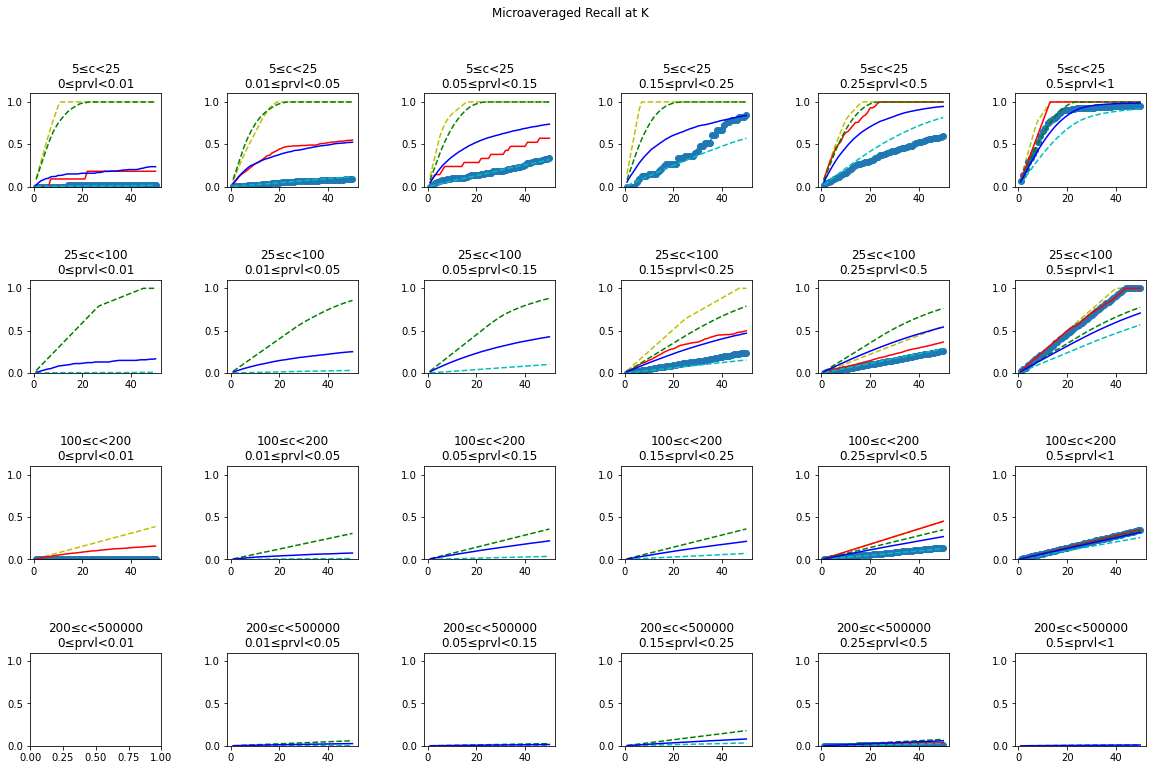

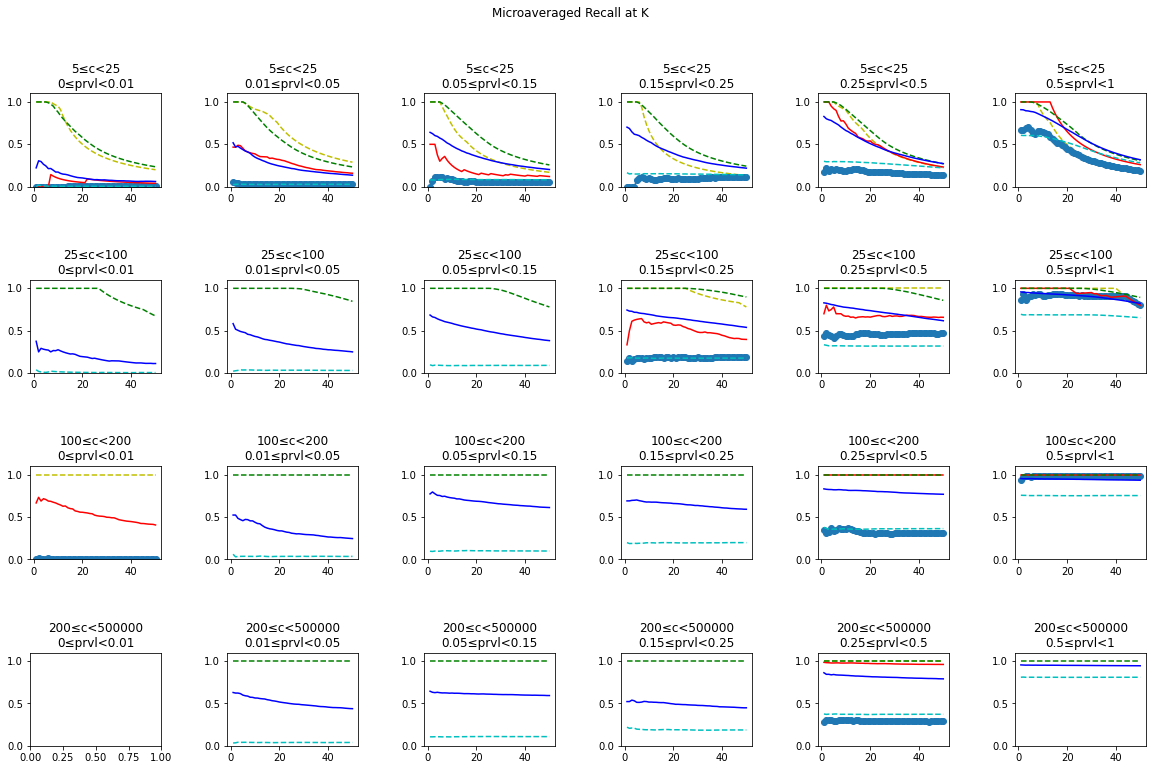

In [21]:
from bssp.common.const import TRAIN_FREQ_BUCKETS, PREVALENCE_BUCKETS

def xyzize(scores_dict, key='synset'):
    x, y, z = [], [], []
    for cutoff, p_at_k_dict in scores_dict.items():
        for k, scores in p_at_k_dict.items():
            if k > cutoff and False:
                continue
            x.append(cutoff)
            y.append(k)
            z.append(scores[key])
    return x, y, z

def plot_surface(scores_dict, key='synset'):
    plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.set_xlabel('occurrence cutoff')
    ax.set_ylabel('k')
    ax.set_zlabel(f'{key} recall')
    #ax.set_zlim(0.3, 1)
    x, y, z = xyzize(scores_dict, key=key)
    ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5)
    plt.show()
    
def plot_p_vs_k(p_at_k_dict, p_at_k_dict_2=None, key='synset'):
    plt.figure(figsize=(7,7))
    ax = plt.axes()
    ax.set_xlabel('k')
    ax.set_ylabel(f'{key} precision')
    ax.set_ylim(0, 1)
    
    k, scores = list(zip(*p_at_k_dict.items()))
    scores = [x[key] for x in scores]
    k = list(k)
    ax.scatter(x=k, y=scores, c=scores)
    if p_at_k_dict_2:
        k, scores = list(zip(*p_at_k_dict_2.items()))
        scores = [x[key] for x in scores]
        k = list(k)       
        ax.scatter(x=k, y=scores, c=scores, marker='x')
    plt.show()    
    
    
def plot_grid(configs, key='label', evals=['rec'], metric='cosine', query_n=1, query_category='all', pos='all'):
    fig, axs = plt.subplots(4,6,figsize=(20,12))
    plt.subplots_adjust(hspace=1.0, wspace=0.5)
    fig.suptitle("Microaveraged " + ("Recall" if evals[0]=='rec' 
                  else "Oracle Recall" if evals[0]=='orec'
                  else "Truncated Recall" if evals[0]=='trec'
                  else "Precision") + " at K")
    
    i = 0
    for min_train_freq, max_train_freq in TRAIN_FREQ_BUCKETS:
        for min_rarity, max_rarity in PREVALENCE_BUCKETS:
            ax = axs[i//6][i%6]
            i += 1
            ax.set_title(f'{min_train_freq}≤c<{max_train_freq}\n{min_rarity}≤prvl<{max_rarity}')
            #ax.set_ylim(0.2, 0.8)
            ax.set_ylim(0, 1.1)
            
            for c in configs:
                metric_ = c.get('metric') or metric
                color_ = c.get('color') or 'pink'
                eval_ = c['eval']
                query_n_ = c.get('query_n') or query_n
                bert_layers_ = c.get('bert_layers') or None
                query_category_ = c.get('query_category') or query_category
                pos_ = c.get('pos') or pos
            
                scores = read_score(
                    eval=eval_, 
                    min_train_freq=min_train_freq, 
                    max_train_freq=max_train_freq, 
                    min_rarity=min_rarity, 
                    max_rarity=max_rarity,
                    metric=metric_,
                    query_n=query_n_,
                    query_category=query_category_,
                    pos=pos_,
                    bert_layers=bert_layers_
                )
                if scores is None:
                    continue
                k, scores = list(zip(*scores.items()))
                scores = [x[key] for x in scores]
                k = list(k)
                #ax.scatter(x=k, y=scores, c=scores)
                ax.plot(k, scores, color_)
    plt.show()
    
#score = read_score(
#    freq_cutoff=5,
#    rarity=5,
#    eval='prec'
#)
#plot_p_vs_k(score, key='synset')
#plot_p_vs_k_grid(key='label', evals=['prec','rec'])
#plot_p_vs_k_grid(key='label', evals=['rec', 'orec'])
#plot_p_vs_k_grid(key='label', evals=['prec'])
#score

#plot_grid([
#    dict(metric='baseline', eval='rec', color='b'),
#    dict(metric='baseline', eval='orec', color='y-'),
#    dict(metric='cosine', eval='rec', color='red', query_n=1, bert_layers=[3]),
#    dict(metric='cosine', eval='rec', color='orange', query_n=3, bert_layers=[3]),
#    dict(metric='cosine', eval='rec', color='yellow', query_n=5, bert_layers=[3]),
#])
#plot_grid([
#    dict(metric='baseline', eval='prec', color='b'),
#    dict(metric='cosine', eval='prec', color='red', query_n=1, bert_layers=[3]),
#    dict(metric='cosine', eval='prec', color='orange', query_n=3, bert_layers=[3]),
#    dict(metric='cosine', eval='prec', color='yellow', query_n=5, bert_layers=[3]),
#])

for i in range(2):
    s = ''
    if i == 1:
        s = 'p'
    plot_grid([
        # layers --------------------------------------------------------------------------------
        #dict(metric='baseline', eval=f'{s}rec', color='b'),
        #dict(metric='baseline', eval=f'o{s}rec', color='y-'),
        
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[0], color='red'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[1], color='orange'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[2], color='yellow'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[3], color='green'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[4], color='blue'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[5], color='indigo'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[6], color='violet'),
        
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[6], color='red'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[7], color='orange'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[8], color='yellow'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[9], color='green'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[10], color='blue'),
        #dict(metric='cosine', eval=f'{s}rec', query_n=1, bert_layers=[11], color='indigo'),
        
        
        dict(metric='baseline', eval=f'o{s}rec', color='y--', query_category='nota'),
        dict(metric='baseline', eval=f'{s}rec', color='o--', query_category='nota'),
        dict(metric='cosine', eval=f'{s}rec', query_n=3, bert_layers=[6], color='r', query_category='nota'),
        
        dict(metric='baseline', eval=f'o{s}rec', color='g--', query_category='non-nota'),
        dict(metric='baseline', eval=f'{s}rec', color='c--', query_category='non-nota'),
        dict(metric='cosine', eval=f'{s}rec', query_n=3, bert_layers=[6], color='b', query_category='non-nota'),
    ])

In [4]:
from bssp.common import paths
for i,row in cosine_data.iterrows():
    print(list(row.keys()))
    print('rarity' in row.keys())
    break
    
tsv_path = paths.freq_tsv_path2('cosine', 1, 'train', 'label')
with open(tsv_path, 'r') as f:
    label_freqs = {k: int(v) for k, v in map(lambda l: l.strip().split('\t'), f)}
        
print(tsv_path)

['sentence', 'label', 'lemma', 'label_freq_in_train', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'label_10', 'label_11', 'label_12', 'label_13', 'label_14', 'label_15', 'label_16', 'label_17', 'label_18', 'label_19', 'label_20', 'label_21', 'label_22', 'label_23', 'label_24', 'label_25', 'label_26', 'label_27', 'label_28', 'label_29', 'label_30', 'label_31', 'label_32', 'label_33', 'label_34', 'label_35', 'label_36', 'label_37', 'label_38', 'label_39', 'label_40', 'label_41', 'label_42', 'label_43', 'label_44', 'label_45', 'label_46', 'label_47', 'label_48', 'label_49', 'label_50', 'lemma_1', 'lemma_2', 'lemma_3', 'lemma_4', 'lemma_5', 'lemma_6', 'lemma_7', 'lemma_8', 'lemma_9', 'lemma_10', 'lemma_11', 'lemma_12', 'lemma_13', 'lemma_14', 'lemma_15', 'lemma_16', 'lemma_17', 'lemma_18', 'lemma_19', 'lemma_20', 'lemma_21', 'lemma_22', 'lemma_23', 'lemma_24', 'lemma_25', 'lemma_26', 'lemma_27', 'lemma_28', 'lemma_29', 'lemma_30', 'lem

FileNotFoundError: [Errno 2] No such file or directory: 'cache/ontonotes_cosine_q1_predictions/train_label_freq.tsv'

In [ ]:
# data columns:
# sentence: original sentence
# label, lemma, synset, label_freq_in_train
# label_i
# synset_i
# lemma_i
# distance_i
list(cosine_data.keys())

def distance_correctness_corr(data, key='label'):
    
    plt.figure(figsize=(8,5))
    ax = plt.axes()
    ax.set_xlabel('k')
    ax.set_ylabel(f'distance correlated with correctness')
    
    df = data.copy()
    for i in range(1,K+1):
        df['correct'] = df[f'{key}_{i}'] == df[f'{key}']
        r = df[['correct', f'distance_{i}']].corr()['correct'][1]
        ax.scatter(i, r, color='blue')
    plt.show()
    

def distance_correctness_histogram(data, key='label'):
    df = data.copy()
    df['first_correct'] = df[f'{key}_1'] == df[f'{key}']
    df[['first_correct', 'distance_1']].pivot(columns='first_correct').distance_1.plot.hist(stacked=True, bins=50)
    plt.show()
    
    
distance_correctness_corr(cosine_data)
#distance_correctness_histogram(euclidean_data[euclidean_data.pos=='r'])
#distance_correctness_histogram(cosine_data)
    

In [ ]:
cosine_scores[5]